In [5]:
import numpy as np
import matplotlib.pyplot as plt
import uproot 
import awkward as ak
import mplhep as hep
from tqdm import tqdm, trange
from pathlib import Path
hep.styles.use("ROOT")


In [ ]:
path = Path('/nfs/disk1/eos/data/water_fill/deployed_source/laserball/')
rootfiles = list(path.glob('*/*.root'))
print(f"Found {len(rootfiles)} files")

def get_rootfile_for_run(run_num):
    for f in rootfiles:
        if f"run{run_num}" in f.as_posix():
            return f

run_number = 149
laserball_pos = np.array([0, 0, 0])

rootfile = uproot.open(get_rootfile_for_run(run_number))
print(f"Rootfile keys: {rootfile.keys()}")

meta = rootfile.get('meta')
events = rootfile.get('events')


Found 67 files
Rootfile keys: ['meta;1', 'events;1', 'channel_info;1']


In [16]:
print("Meta Data:")
for key in meta.keys():
    if key == 'macro':
        continue
    print(f"{key:>30}: {meta[key].array()[0]}")

Meta Data:
                        nfiles: 4
               pedestal_window: 10
                 window_length: 100
         analysis_code_version: 2.0
                     threshold: -5.0
                          pmtx: [-1.04e+03, -1.04e+03, -1.04e+03, -1.04e+03, ..., -291, -585, -592, -298]
                          pmty: [137, 137, 137, 137, 137, 137, 137, ..., 164, -327, -489, -489, -327, 0, 164]
                          pmtz: [658, 439, 220, 0, -220, ..., -1.48e+03, -1.45e+03, -1.48e+03, -1.53e+03]


In [18]:
print("Event Data:")
for key in events.keys():
    print(f"{key:>30}: {events[key].array()[2]}")

Event Data:
                  event_number: 3
                          nhit: 15
                  total_charge: 27.8281250000005
                        deltat: 1000.0
                       channel: [4, 5, 0, 8, 6, 12, 12, 10, 13, 3, 6, 10, 12, 6, 1]
                         board: [0, 0, 1, 3, 5, 5, 6, 8, 8, 9, 10, 10, 12, 13, 15]
                           lcn: [4, 5, 16, 56, 86, 92, 108, 138, 141, 147, 166, 170, 204, 214, 241]
                          time: [121, 150, 120, 121, 118, 122, 119, ..., 168, 122, 118, 122, 121, 99.1, 120]
                channel15_time: [128, 128, 128, 128, 128, 128, 128, 127, 127, 126, 128, 128, 128, 0, 126]
                      pedestal: [1.76, 1.77, 1.77, 1.76, 1.76, 1.76, ..., 1.75, 1.77, 1.75, 1.76, 1.76, 1.74]
                        charge: [1.46, 1.66, 1.73, 0.635, 1.68, 1.79, ..., 2.06, 2.08, 2.7, 1.89, 2.31, 1.5]
                  charge_short: [1.42, 1.34, 1.59, 0.6, 1.57, 1.51, 1.51, ..., 1.98, 1.88, 2.34, 1.73, 2, 1.33]
                  

In [ ]:
def flat_numpy_array(entry):
    return ak.to_numpy(ak.flatten(entry.array()))


n = 1.337 # water at 515 nm
c = 299.792 # in mm / ns
v_water = c/n 

pmtx = ak.to_numpy(meta['pmtx'].array()[0])
pmty = ak.to_numpy(meta['pmty'].array()[0])
pmtz = ak.to_numpy(meta['pmtz'].array()[0])
pmt_pos = np.array([pmtx, pmty, pmtz]).T

time_of_flight = np.linalg.norm(pmt_pos - laserball_pos[np.newaxis, :], axis=-1) / v_water # time to travel from laserball to PMT


all_channel = flat_numpy_array(events['channel']) # channel number: 0-15
all_board = flat_numpy_array(events['board']) # CAEN board: 0-16
all_lcn = flat_numpy_array(events['lcn']) # logical channel number: 0-219
all_time = flat_numpy_array(events['time']) # time of pulse relative to trigger time 
all_channel15_time = flat_numpy_array(events['channel15_time']) # trigger time 
all_pedestal_time = flat_numpy_array(events['pedestal']) 
all_charge_time = flat_numpy_array(events['charge']) 
all_charge_short_time = flat_numpy_array(events['charge_short']) 
all_ncrossings = flat_numpy_array(events['ncrossings']) 
all_pulse_height = flat_numpy_array(events['pulse_height'])
all_fitted_time = flat_numpy_array(events['fitted_time']) # so then how is time calculated?
num_events = len(events['nhit'].array(library='numpy'))

# # subtract cable delays and time of flight from all pulses times
# all_time -= (CABLE_DELAYS[all_lcn] + time_of_flight[all_lcn]) 
# all_fitted_time -= (CABLE_DELAYS[all_lcn] + time_of_flight[all_lcn])

# subtract time of flight from all pulses times
all_time -= time_of_flight[all_lcn] 
all_fitted_time -= time_of_flight[all_lcn]


[5.54660341 5.09288843 4.80011817 4.69847582 4.80011817 5.09288843
 5.54660341 5.54660339 5.09288841 4.80011814 4.6984758  4.80011814
 5.09288841 5.54660339 5.54660334 0.00775342 4.80011809 4.69847575
 4.80011809 5.09288836 5.54660334 5.54660334 5.09288836 4.80011809
 4.69847575 4.80011809 5.09288836 5.54660334 5.54660339 5.09288841
 4.80011814 0.00775342 4.80011814 5.09288841 5.54660339 5.54660341
 5.09288843 4.80011817 4.69847582 4.80011817 5.09288843 5.54660341
 5.54660341 5.09288843 4.80011817 4.69847582 4.80011817 0.00775342
 5.54660341 5.54660339 5.09288841 4.80011814 4.6984758  4.80011814
 5.09288841 5.54660339 5.54660334 5.09288836 4.80011809 4.69847575
 4.80011809 5.09288836 5.54660334 0.00775342 5.09288836 4.80011809
 4.69847575 4.80011809 5.09288836 5.54660334 5.54660339 5.09288841
 4.80011814 4.6984758  4.80011814 5.09288841 5.54660339 5.54660341
 5.09288843 0.00775342 4.69847582 4.80011817 5.09288843 5.54660341
 5.54660341 5.09288843 4.80011817 4.69847582 4.80011817 5.0928

In [ ]:



# In time NHIT of all even
plt.hist(events['nhit'].array(), bins=np.arange(220), histtype='step')
plt.xlabel("nhit")
plt.semilogy()

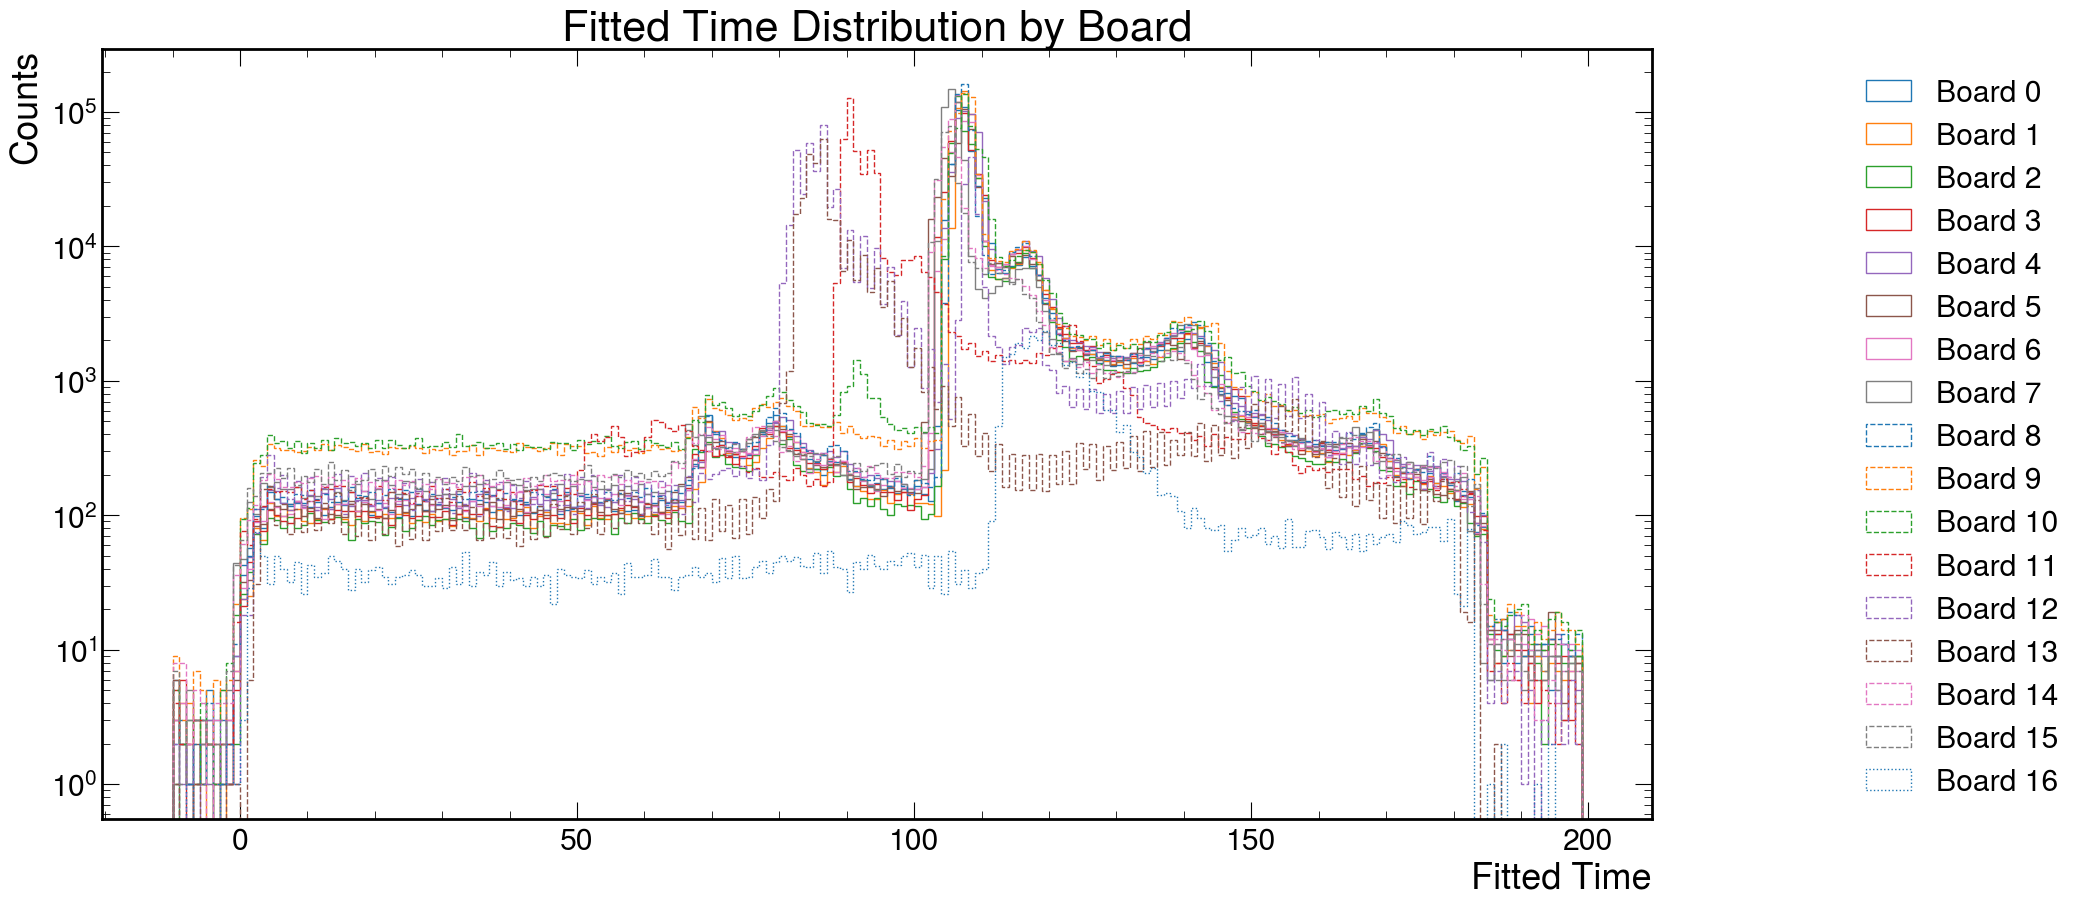

In [23]:
plt.figure(figsize=(20,10))
# Example: Plotting each board with distinct colors and line styles
unique_boards = np.unique(all_board)  # Get unique board numbers
colors = plt.cm.tab10.colors[:8]  # Use 8 main colors from the 'tab10' colormap
line_styles = ['-', '--', ':', '-.']  # Define line styles

for i, board in enumerate(unique_boards):
    board_mask = all_board == board
    color = colors[i % len(colors)]  # Cycle through colors
    line_style = line_styles[i // len(colors) % len(line_styles)]  # Cycle through line styles
    plt.hist(all_fitted_time[board_mask], bins=np.arange(-10, 200), 
             label=f"Board {board}", histtype='step', color=color, linestyle=line_style)

plt.semilogy()
plt.legend(loc='upper center',bbox_to_anchor=(1.2, 1), ncol=1)
plt.xlabel("Fitted Time")
plt.ylabel("Counts")
plt.title("Fitted Time Distribution by Board")
plt.show()

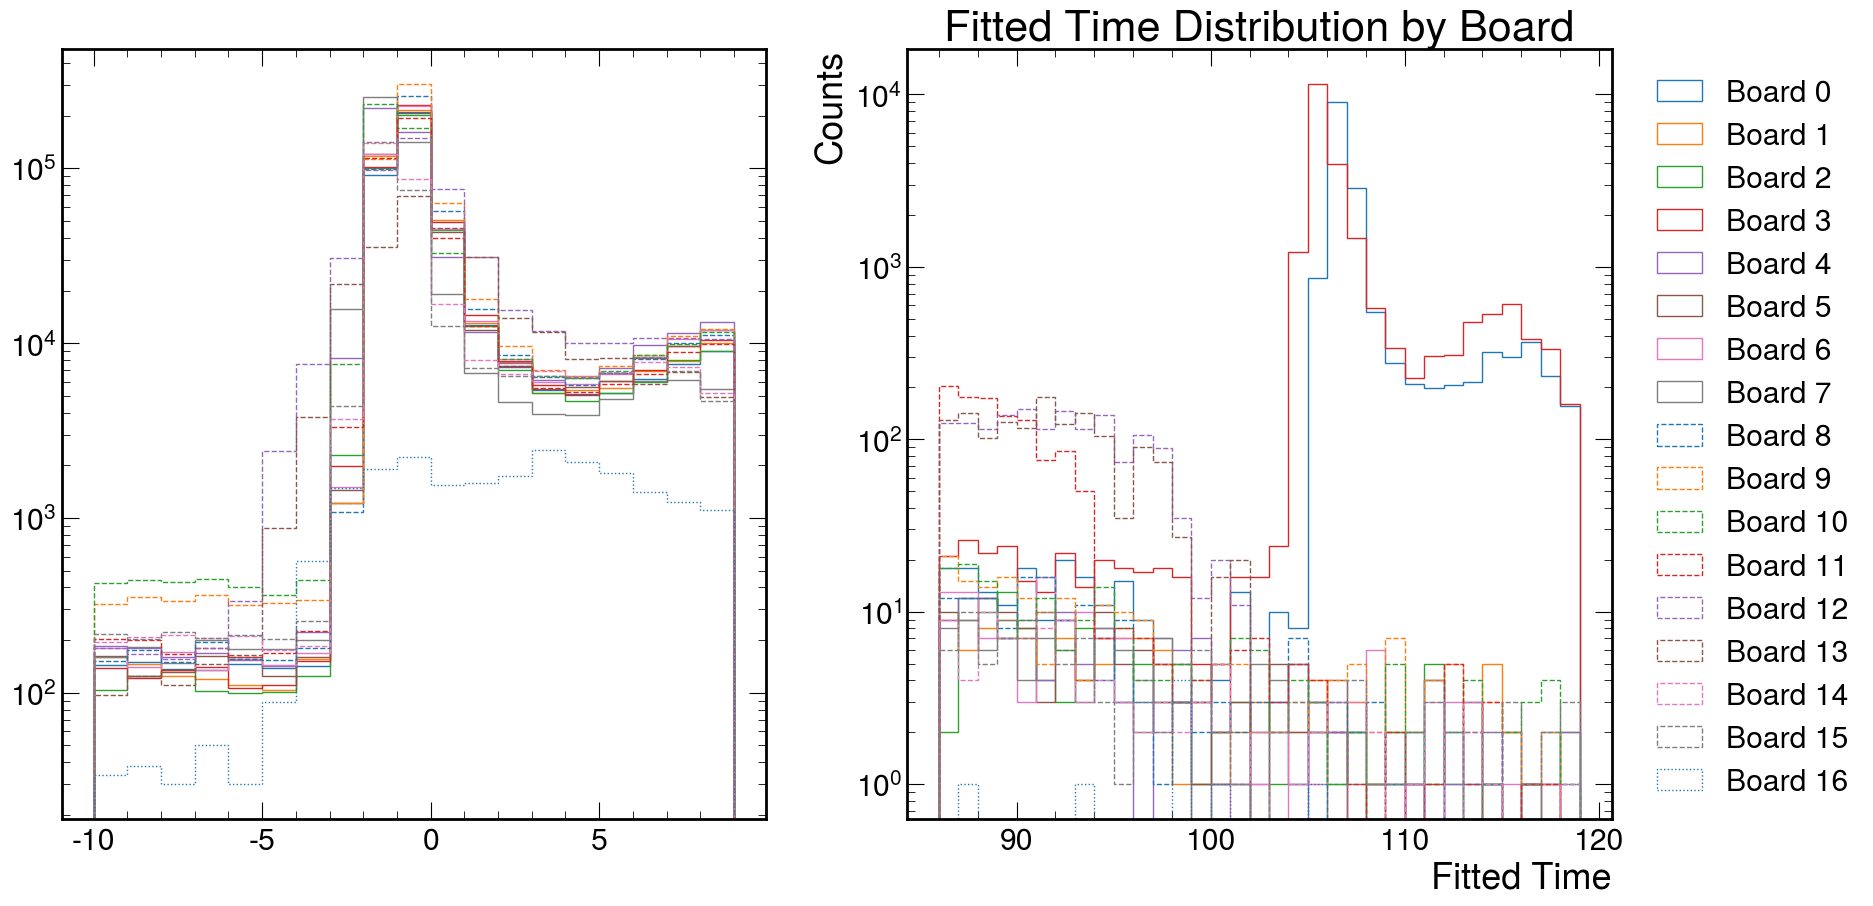

In [59]:

fig,axes=plt.subplots(1,2,figsize=(20,10))
# Example: Plotting each board with distinct colors and line styles
unique_boards = np.unique(all_board)  # Get unique board numbers
colors = plt.cm.tab10.colors[:8]  # Use 8 main colors from the 'tab10' colormap
line_styles = ['-', '--', ':', '-.']  # Define line styles

for i, board in enumerate(unique_boards):
    board_mask = all_board == board
    color = colors[i % len(colors)]  # Cycle through colors
    line_style = line_styles[i // len(colors) % len(line_styles)]  # Cycle through line styles
    axes[0].hist(all_fitted_time[board_mask], bins=np.arange(-10, 10), 
             label=f"Board {board}", histtype='step', color=color, linestyle=line_style)
    axes[1].hist(all_fitted_time[board_mask], bins=np.arange(86, 120), 
             label=f"Board {board}", histtype='step', color=color, linestyle=line_style)
    axes[0].semilogy()
    axes[1].semilogy()

plt.legend(loc='upper center',bbox_to_anchor=(1.2, 1), ncol=1)
plt.xlabel("Fitted Time")
plt.ylabel("Counts")
plt.title("Fitted Time Distribution by Board")
plt.show()

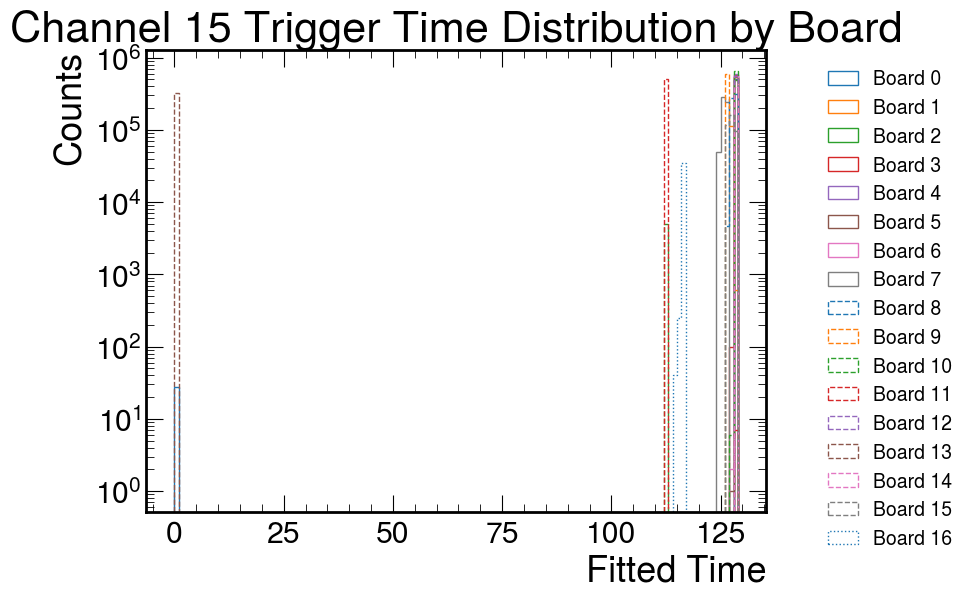

In [35]:
plt.figure(figsize=(8,6))
# Example: Plotting each board with distinct colors and line styles
unique_boards = np.unique(all_board)  # Get unique board numbers
colors = plt.cm.tab10.colors[:8]  # Use 8 main colors from the 'tab10' colormap
line_styles = ['-', '--', ':', '-.']  # Define line styles

for i, board in enumerate(unique_boards):
    board_mask = all_board == board
    color = colors[i % len(colors)]  # Cycle through colors
    line_style = line_styles[i // len(colors) % len(line_styles)]  # Cycle through line styles
    plt.hist(all_channel15_time[board_mask], bins=np.arange(0, 130), 
             label=f"Board {board}", histtype='step', color=color, linestyle=line_style)

plt.semilogy()
plt.legend(loc='upper center',bbox_to_anchor=(1.2, 1), ncol=1, fontsize=14)
plt.xlabel("Fitted Time")
plt.ylabel("Counts")
plt.title("Channel 15 Trigger Time Distribution by Board")
plt.show()

In [74]:


# # all_fitted_time_corrected = all_fitted_time + 16 * (all_channel15_time<114)

# bad_hit_mask = np.logical_and(all_fitted_time < 9000, all_channel15_time<113)
# bad_hit_mask = np.logical_and(bad_hit_mask, all_channel15_time > 110)
# bad_hit_mask = np.logical_and(bad_hit_mask, all_board == 4)
# all_fitted_time_corrected = np.array(all_fitted_time, copy=True)
# print(len(all_fitted_time_corrected[bad_hit_mask]), "bad hits")
# all_fitted_time_corrected[bad_hit_mask] += 1e9/62.5e6 # Shift by 1 tick
# hep.histplot(np.histogram(all_fitted_time_corrected, bins=100, range=(-20, 20)), yerr=True, color='k')
# plt.semilogy()
# plt.xlabel("Fitted time [ns]")
# plt.title(f"Run {run_number}")
# plt.xlim(-20, 20)
# plt.show()



In [83]:
# Many fitted times 6-7 clock ticks delayed
# The delay is 105 ns and not 96 or 112
# The cable delays are wrong!!!

# Maybe shouldn't do a timing cut on this data... we know it is all from Cherenkov light


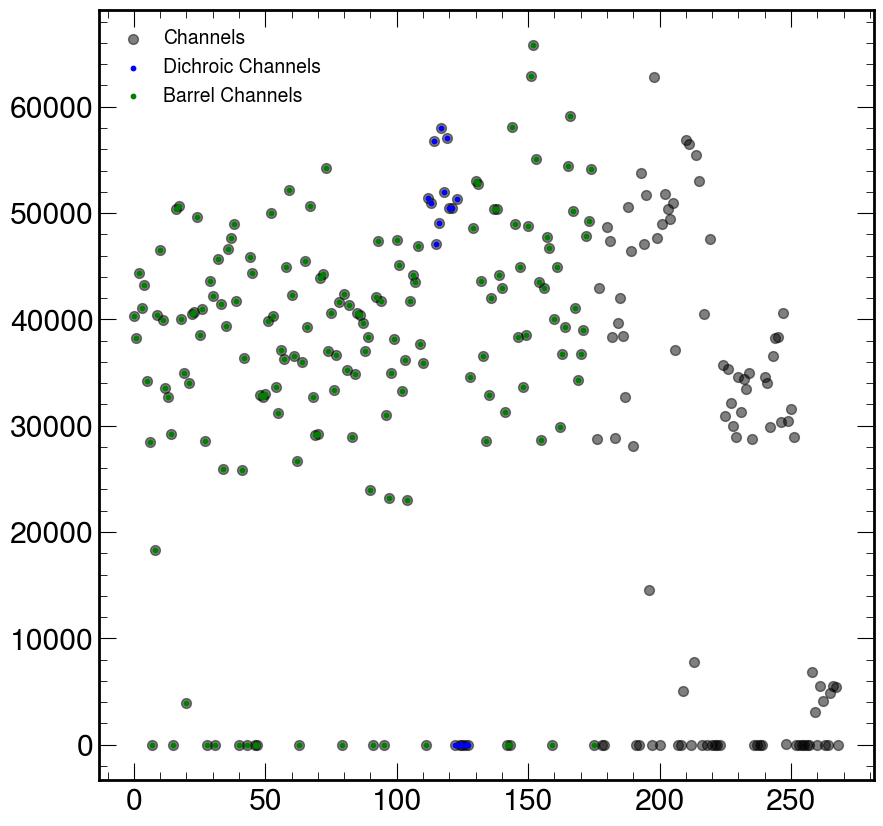

In [ ]:
lcns = np.arange(np.max(all_lcn)+1)

#logan_channels = [7, 15, 28, 31, 40, 46, 47, 63, 79, 91, 95, 111, 122, 124, 125, 126, 127, 142, 143, 159, 175, 178, 179, 191, 192, 197, 200, 207, 208, 212, 216, 218, 220, 221, 222, 223, 236, 237, 238, 239, 252, 253, 254, 255, 256, 257, 260, 263, 264, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299]
#$logan_mask = np.isin(lcns, logan_channels)

barrel_channels = []
barrel_boards = [0, 1, 2, 3, 4, 5, 6, 8, 9, 10]
barrel_channels.extend([16 * board + i for board in barrel_boards for i in range(16)])

dichroic_channels = []
dichroic_boards = [7]
dichroic_channels.extend([16 * board + i for board in dichroic_boards for i in range(16)])



nhit_per_lcn = np.zeros(len(lcns))
for lcn in lcns:
    all_lcn_hits = all_fitted_time[all_lcn == lcn]
    nhit_per_lcn[lcn] = len(all_lcn_hits)
#plt.scatter(lcns[~logan_mask],nhit_per_lcn[~logan_mask]/num_events,s=50,alpha=0.3,color='black',label='Good Channels')
plt.scatter(lcns,nhit_per_lcn,s=50,alpha=0.5,color='black',label='Channels')
plt.scatter(lcns[dichroic_channels],nhit_per_lcn[dichroic_channels],s=10,alpha=1,color='blue',label='Dichroic Channels')
plt.scatter(lcns[barrel_channels],nhit_per_lcn[barrel_channels],s=10,alpha=1,color='green',label='Barrel Channels')
plt.legend(fontsize=14)




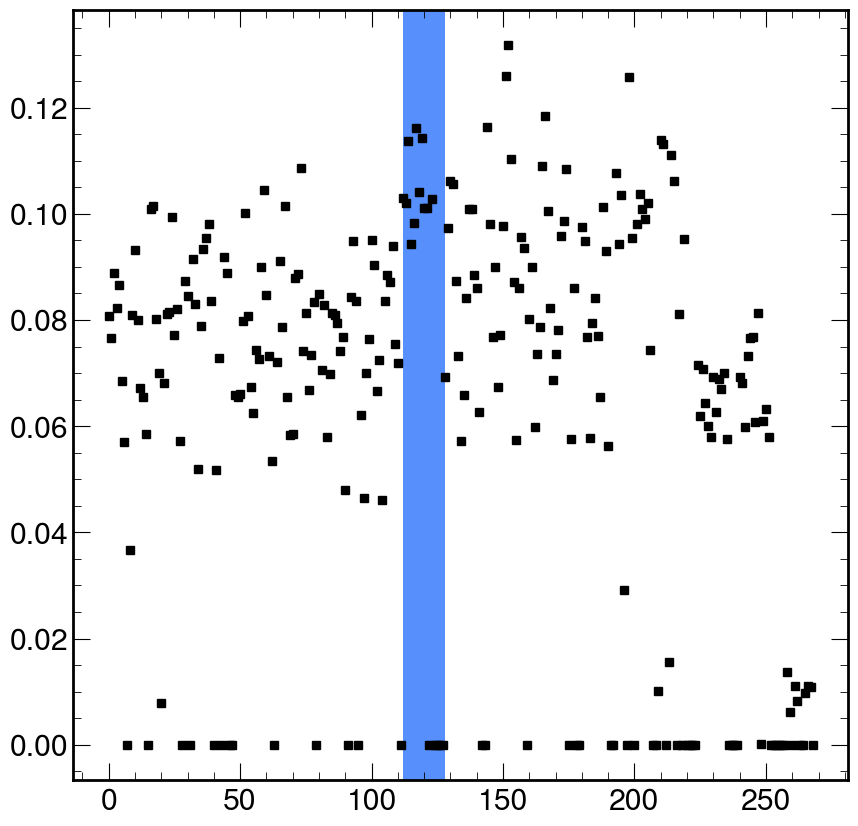

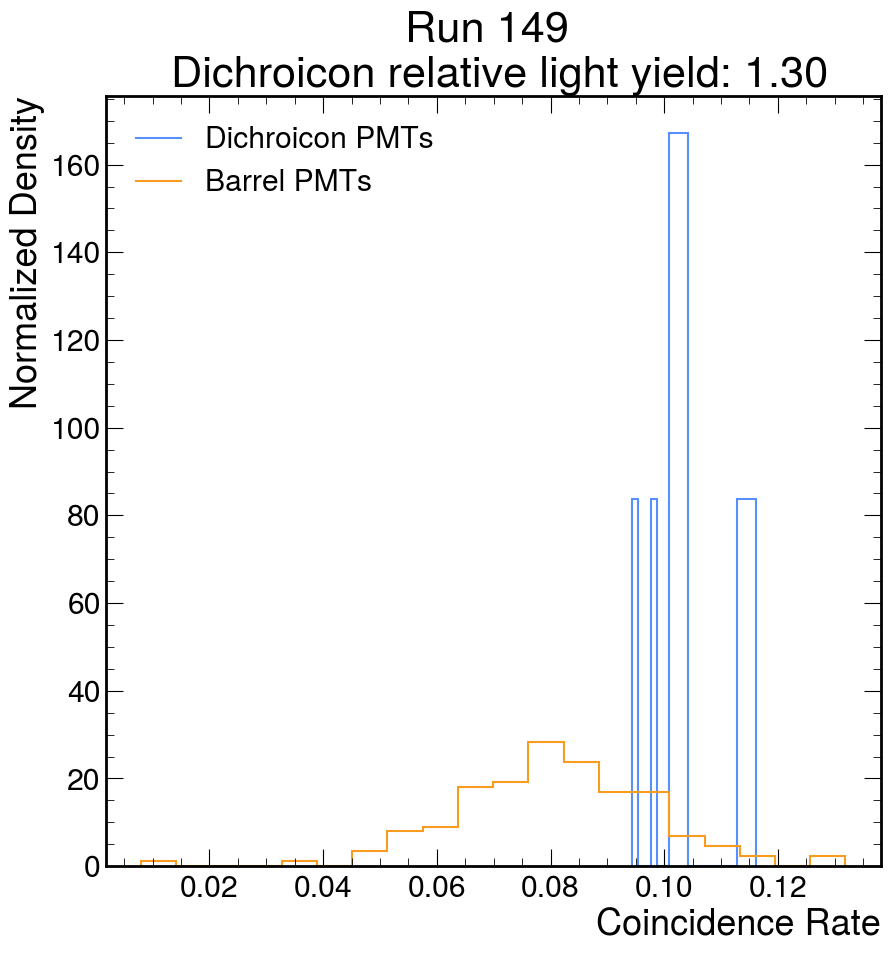

In [ ]:
# Compute average nhit for each channel
# Assume single PE -- laser ball is low intensity enough that this is probably ok.



logan_badchannels = [7, 15, 28, 31, 40, 46, 47, 63, 79, 91, 95, 111, 122, 124, 125, 126, 127, 142, 143, 159, 175, 178, 179, 191, 192, 197, 200, 207, 208, 212, 216, 218, 220, 221, 222, 223, 236, 237, 238, 239, 252, 253, 254, 255, 256, 257, 260, 263, 264, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299]
coincidence_rate_cut = 0.001
max_lcn = np.max(all_lcn)
lcns = np.arange(max_lcn+1)
nhit_per_channel = np.zeros(max_lcn+1)
for lcn in range(max_lcn+1):
    if lcn in logan_badchannels: continue
    all_hits_for_channel = all_fitted_time[all_lcn == lcn]
    nhit_per_channel[lcn] = len(all_hits_for_channel)
# nhit_per_channel[nhit_per_channel < 2] = np.nan
plt.plot(lcns, nhit_per_channel/num_events, 'ks')
plt.axvspan(7*16, 8*16)
plt.show()
coincidence_rate = nhit_per_channel / num_events
dichroicon_mask = (lcns // 16 == 7) & (coincidence_rate >= coincidence_rate_cut)
barrel_mask = ((lcns // 16 < 7) | ((lcns // 16 >= 8) & (lcns // 16 <= 10))) & (coincidence_rate >= coincidence_rate_cut)
hep.histplot(np.histogram(coincidence_rate[dichroicon_mask], bins=20),
             label='Dichroicon PMTs', density=True)
hep.histplot(np.histogram(coincidence_rate[barrel_mask], bins=20),
             label='Barrel PMTs', density=True)
plt.xlabel("Coincidence Rate")
plt.ylabel("Normalized Density")
dichroicon_relative_lightyield = np.mean(coincidence_rate[dichroicon_mask]) / np.mean(coincidence_rate[barrel_mask])
plt.title(f"Run {run_number} \n Dichroicon relative light yield: {dichroicon_relative_lightyield:.2f}")
plt.legend()

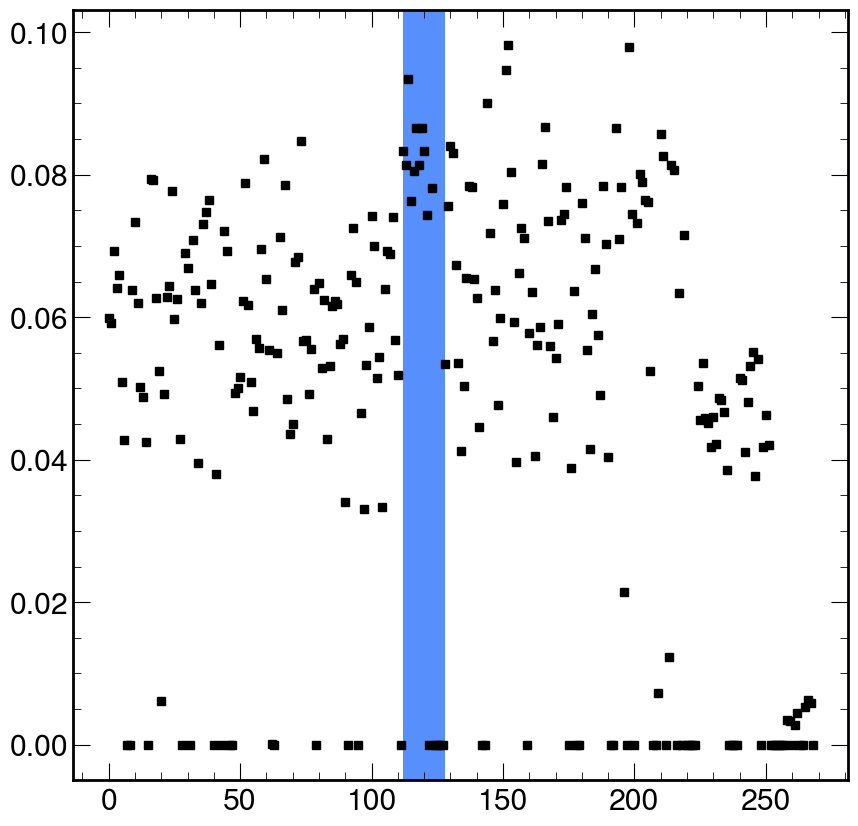

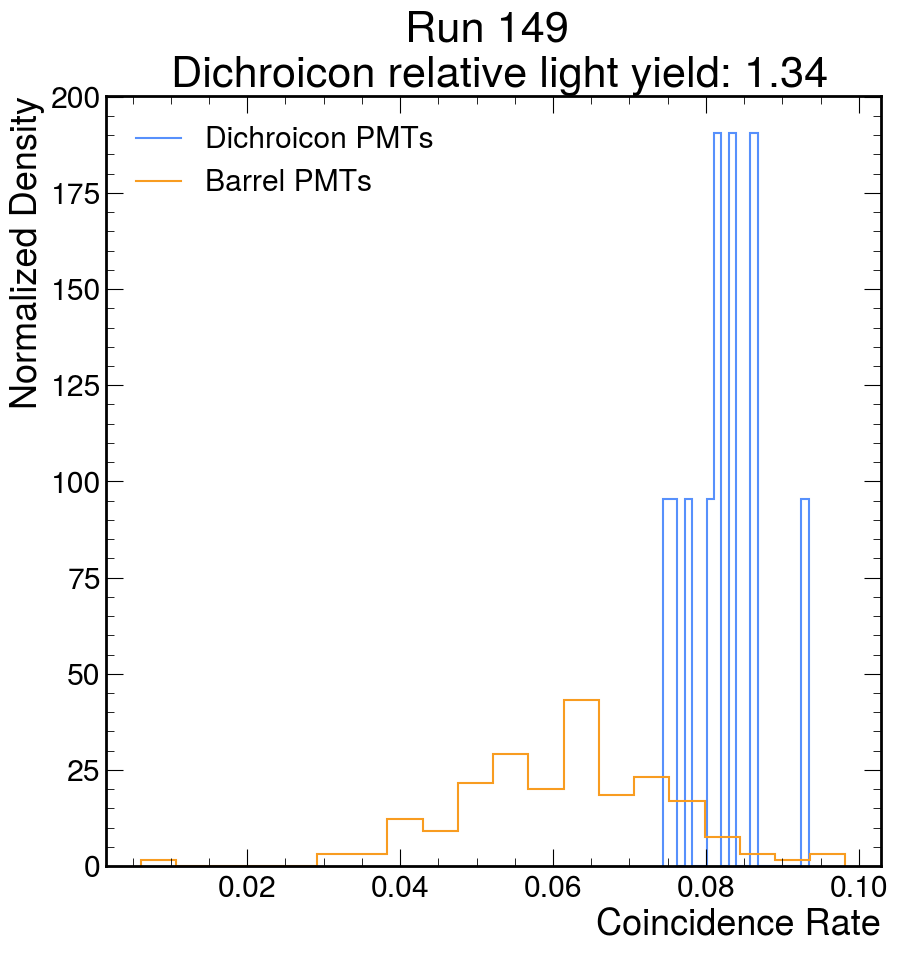

In [80]:
# Compute average nhit for each channel
# Assume single PE -- laser ball is low intensity enough that this is probably ok.
prompt_cut_min = -5
prompt_cut_max = 5

logan_badchannels = [7, 15, 28, 31, 40, 46, 47, 63, 79, 91, 95, 111, 122, 124, 125, 126, 127, 142, 143, 159, 175, 178, 179, 191, 192, 197, 200, 207, 208, 212, 216, 218, 220, 221, 222, 223, 236, 237, 238, 239, 252, 253, 254, 255, 256, 257, 260, 263, 264, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299]
coincidence_rate_cut = 0.001
max_lcn = np.max(all_lcn)
lcns = np.arange(max_lcn+1)
nhit_per_channel = np.zeros(max_lcn+1)
for lcn in range(max_lcn+1):
    if lcn in logan_badchannels: continue
    all_hits_for_channel = all_fitted_time[all_lcn == lcn]
    nhit_per_channel[lcn] = len(all_hits_for_channel[(all_hits_for_channel > prompt_cut_min) & (all_hits_for_channel < prompt_cut_max)])
# nhit_per_channel[nhit_per_channel < 2] = np.nan
plt.plot(lcns, nhit_per_channel/num_events, 'ks')
plt.axvspan(7*16, 8*16)
plt.show()
coincidence_rate = nhit_per_channel / num_events
dichroicon_mask = (lcns // 16 == 7) & (coincidence_rate >= coincidence_rate_cut)
barrel_mask = ((lcns // 16 < 7) | ((lcns // 16 >= 8) & (lcns // 16 <= 10))) & (coincidence_rate >= coincidence_rate_cut)
hep.histplot(np.histogram(coincidence_rate[dichroicon_mask], bins=20),
             label='Dichroicon PMTs', density=True)
hep.histplot(np.histogram(coincidence_rate[barrel_mask], bins=20),
             label='Barrel PMTs', density=True)
plt.xlabel("Coincidence Rate")
plt.ylabel("Normalized Density")
dichroicon_relative_lightyield = np.mean(coincidence_rate[dichroicon_mask]) / np.mean(coincidence_rate[barrel_mask])
plt.title(f"Run {run_number} \n Dichroicon relative light yield: {dichroicon_relative_lightyield:.2f}")
plt.legend()

In [42]:
barrel_pmt_nhits = []
dichroicon_pmt_nhits = []
for lcn, ncrossing in enumerate(ncrossing_per_channel):
    board_id = lcn // 16
    if board_id < 7:
        barrel_pmt_nhits.append(ncrossing)
    elif board_id == 7:
        dichroicon_pmt_nhits.append(ncrossing)

barrel_pmt_nhits = np.asarray(barrel_pmt_nhits)
barrel_pmt_nhits = barrel_pmt_nhits[barrel_pmt_nhits > 20]
dichroicon_pmt_nhits = np.asarray(dichroicon_pmt_nhits)
dichroicon_pmt_nhits = dichroicon_pmt_nhits[dichroicon_pmt_nhits > 20]
plt.figure(figsize=(14, 8))
hep.histplot(np.histogram(barrel_pmt_nhits, bins=10, range=(0, 2000)),
             density=True, yerr=True, color='r',
             label=f"Barrel PMTs, Mean = {np.mean(barrel_pmt_nhits):.2f}, Std = {np.std(barrel_pmt_nhits):.2f}")
hep.histplot(np.histogram(dichroicon_pmt_nhits, bins=10, range=(0, 2000)),
             density=True, yerr=True, color='b',
             label=f"Dichroic PMTs, Mean = {np.mean(dichroicon_pmt_nhits):.2f}, Std = {np.std(dichroicon_pmt_nhits):.2f}")
plt.xlabel('NCrossings')
plt.title("Run 46")
plt.legend()

NameError: name 'ncrossing_per_channel' is not defined

In [ ]:
hep.histplot(np.histogram(all_ncrossings[all_board==7], bins=np.arange(10)), density=True)
hep.histplot(np.histogram(all_ncrossings[all_board<7], bins=np.arange(10)), density=True)